# Cohen Yuval
### ID : 208570184

# Map Of Content
1. Data Scraping
2. Dataset generation using NRE or any other algorithm , deep learning not allowed
3. 2-5 subject tags for each verdict using itf-idf or any other algorithm
4. 2-5 subject tags for each verdict using Word2Vec (same as 3)
-  Compare (3) and (4)
5. Dataset Statistics
    - In Certain TimeFrame:
    - a. Number of verdict of each judge
    - b. Number of verdicts each judge gave in the top 10 popular subject tags
6. Use RNN to perform NER recognision for dataset generation(2) 
7. - Compare 2 and 6
8. Use RNN to peform sentiment analysis on each verdict,  add sentiment Column for dataset (POSITIVE NETURAL NEGETIVE)
9. Dataset Statistics with extra stats:
    - number of verdicts each judge gave for every sentiment type
    - In Certain TimeFrame: num of verdicts all judges gave for every sentiment type  
10. 2-5 subject tags for each verdict using AUTOENCODER  
- Compare (3), (4) , (10)

# Resources

- alefbert : https://github.com/OnlpLab/AlephBERT

# IMPORTS

In [395]:
import os
import datasets
import typing
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import random
from gensim import utils
import datetime
import matplotlib.pyplot as plt
import regex as re
import transformers
import string

import numpy as np
from pprint import pprint
from tqdm import tqdm,tqdm_notebook
from collections import Counter
import json
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec,LineSentence
from gensim.corpora import WikiCorpus
from multiprocessing import cpu_count
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel,pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.corpus import *
from nltk.tokenize import word_tokenize

import fasttext.util
import fasttext
import time
import multiprocessing
import spacy
import word2vec
import tensorflow
from torch.utils.data import Dataset,DataLoader
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy.random import seed
from gensim.corpora import WikiCorpus
import math
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from collections import Counter
#from conlleval import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed(1)
tensorflow.random.set_seed(2)
pd.set_option('display.max_columns', None)

# DOWNLOADS

In [294]:
def get_dirs():
    dirs = []
    batches = []
    for _ ,dirname, files in os.walk("./../data"):
        dirs.append(dirname)
        f = [file for file in files if file.endswith(".csv")]
        if len(f) == 0:
            continue
        f = f[0]
        batches.append(f)
    queries = dirs[0]
    return queries

def get_data_path(base_dir,query):
    path = os.path.join(base_dir,query,"csv",f"{query}.csv")
    return path

def data_gen():
    base_dir = "./../data"
    queries = get_dirs()
    for query in queries:
        path = get_data_path(base_dir,query)
        batch = pd.read_csv(path)
        yield batch

        
queries = get_dirs()
    

Index(['Unnamed: 0', 'id', 'filename', 'query', 'title', 'procedures',
       'judge_first_names', 'judge_last_names', 'judges_genders',
       'team_one_names', 'team_one', 'team_one_extra', 'team_two_names',
       'team_two', 'team_two_extra', 'team_one_lawyers_teams_names',
       'team_one_lawyers', 'team_two_lawyers_teams_names', 'team_two_lawyers',
       'date', 'all_lawyers_teams_names', 'all_lawyers', 'text', 'state'],
      dtype='object')

In [207]:
firsts.iloc[0]

Unnamed: 0                                                                      0
id                                                                              0
filename                                                             23042080.pdf
query                                                                        עדים
title                                                          העליון המשפט  בבית
procedures                                                           4208/23  פ"ע
judge_first_names                                                               א
judge_last_names                                                             חיות
judges_genders                                                             female
team_one_names                                                             המערער
team_one                                                               אביטן גולן
team_one_extra                                                                NaN
team_two_names  

In [208]:
item = firsts.iloc[7]





In [362]:
filename = item['filename']
procedures = item['procedures']
first_names = item['judge_first_names']
last_names = item['judge_last_names']
judge_genders = item['judges_genders']
team_one_names = item['team_one_names']
team_one = item['team_one']
team_one_extra = item['team_one']
team_one_lawyers_teams_names = item['team_one_lawyers_teams_names']
team_one_lawyers = item['team_one_lawyers']
team_two_names = item['team_two_names']
team_two = item['team_two']
team_two_extra = item['team_two']
team_two_lawyers_teams_names = item['team_two_lawyers_teams_names']
team_two_lawyers = item['team_two_lawyers']
date = item['date']
lawyers_teams = item['all_lawyers_teams_names']
lawyers = item['all_lawyers']
text = item['text']

def string_to_list(lst_str:str):
    return lst_str.split("|")

def string_to_nested_list(lst_str:str):
    lst = []
    for item in lst_str.split("@"):
        lst.append(string_to_list(item))
    return lst


last = string_to_list(last_names)
first = string_to_list(first_names)
judges = [last[i] +"' "+ first[i] for i in range(len(first))]
genders = string_to_list(judge_genders)
verdict_procedures = string_to_list(procedures)
team_one_represent = string_to_list(team_one_lawyers_teams_names)
team_one_represent_lawyers = string_to_nested_list(team_one_lawyers)
team_two_represent = string_to_list(team_two_lawyers_teams_names)
team_two_represent_lawyers = string_to_nested_list(team_two_lawyers)



In [211]:
# title = item['title']
# last = last_names.strip("['']").replace(", '",",").replace("',",",").split(",")
# first = first_names.strip("['']").split(",")

# first = [f.strip().replace("'","") for f in first]
# judges = [last[i] + "' " + first[i] for i in range(len(first))]
# alefss = alefs
# # alefs = [alef for alef in alefs]
# print(alefss)

# genders = judge_genders.strip("[]").split(",")
# genders = [gender.strip().strip("''") for gender in genders]



In [212]:
# Download wiki corpus from https://dumps.wikimedia.org/hewiki/latest/
def download_wiki_corpus():
    if os.path.exists("./wiki.he.text"):
        print('True')
        return 
    inp = "./../hewiki-latest-pages-articles.xml.bz2"
    outp = "./wiki.he.text"
    i = 0

    print("Starting to create wiki corpus")
    output = open(outp, 'w')
    space = " "
    wiki = WikiCorpus(inp, dictionary={})
    for text in wiki.get_texts():
        article = space.join([t.encode('utf-8').decode("utf-8") for t in text])

        output.write("{}\n".format(article.encode("utf-8")))
        i += 1
        if (i % 1000 == 0):
            print("Saved " + str(i) + " articles")

    output.close()
    print("Finished - Saved " + str(i) + " articles")




In [213]:
download_wiki_corpus()

True


In [214]:
# model_ft_name = 'avichr/Legal-heBERT_ft' # for the fine-tuned HeBERT model 
# model_name = 'avichr/Legal-heBERT' # for legal HeBERT model trained from scratch

# tokenizer_ft = AutoTokenizer.from_pretrained(model_ft_name)
# model_ft = AutoModel.from_pretrained(model_ft_name)

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

In [215]:

# fill_mask = pipeline(
#     "fill-mask",
#     model=model_name,
# )



# fill_mask("הקורונה לקחה את [MASK] ולנו לא נשאר דבר.")

# NER = pipeline(
#     "token-classification",
#     model="avichr/heBERT_NER",
#     tokenizer="avichr/heBERT_NER",
# )

# NER('דויד לומד באוניברסיטה העברית שבירושלים')


In [216]:


# def train(inp = "wiki.he.text",out_model = "wiki.he.fasttext.model",
#           alg = "CBOW"):
#     start = time.time()
#     if alg == "skipgram":
#         # Skipgram model
#         model = fasttext.skipgram(inp, out_model)
#         print(model.words) # list of words in dictionary
#     else:
#         # CBOW model
#         model = fasttext.train_unsupervised(inp, out_model)
#         print(model.words) # list of words in dictionary
#     print(time.time()-start)
#     model.save(out_model)



# def getModel(model = "wiki.he.fasttext.model.bin"):
#     # model = fasttext.load_model('./../cc.he.300.bin')
#     model = fasttext.load_model(model,encoding='utf-8', encoding_model='utf-8', encoding_vectors='utf-8')
#     return model
    
# model = getModel()


In [217]:


# def train(inp = "wiki.he.text",out_model = "wiki.he.word2vec.model"):

#     start = time.time()

#     model = Word2Vec(LineSentence(inp), sg = 1, # 0=CBOW , 1= SkipGram
#                      size=100, window=5, min_count=5, workers=multiprocessing.cpu_count())

#     # trim unneeded model memory = use (much) less RAM
#     model.init_sims(replace=True)

#     print(time.time()-start)

#     model.save(out_model)

# def getModel(model = "wiki.he.word2vec.model"):

#     model = Word2Vec.load(model)

#     return model




In [218]:
# import word2vec
# import fasttxt
# import numpy as np
# from gensim.matutils import unitvec


# def test(model,positive,negative,test_words):

#     mean = []
#     for pos_word in positive:
#         mean.append(1.0 * np.array(model[pos_word]))

#     for neg_word in negative:
#         mean.append(-1.0 * np.array(model[neg_word]))

#     # compute the weighted average of all words
#     mean = unitvec(np.array(mean).mean(axis=0))

#     scores = {}
#     for word in test_words:

#         if word not in positive + negative:

#             test_word = unitvec(np.array(model[word]))

#             # Cosine Similarity
#             scores[word] = np.dot(test_word, mean)

#     print(sorted(scores, key=scores.get, reverse=True)[:1])

# TRAIN = False

# if TRAIN:
#     print("Training Word2vec")
#     word2vec.train()

#     print("Training Fasttext")
#     fasttxt.train()


# positive_words = ["מלכה","גבר"]

# negative_words = ["מלך"]

# # Test Word2vec
# print("Testing Word2vec")
# model = word2vec.getModel()
# test(model,positive_words,negative_words,model.vocab)

# # Test Fasttext
# print("Testing Fasttext")
# model = fasttxt.getModel()
# test(model,positive_words,negative_words,model.words)

In [219]:
nltk.download("all",download_dir='./data/nltk')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to ./data/nltk...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to ./data/nltk...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     ./data/nltk...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     ./data/nltk...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to ./data/nltk...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to ./data/nltk...
[nltk_data]    |   Package bcp47 is already up-to-date!
[nltk_data]    | Downloading package biocr

[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to ./data/nltk...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to ./data/nltk...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package paradigms to ./data/nltk...
[nltk_data]    |   Package paradigms is already up-to-date!
[nltk_data]    | Downloading package pe08 to ./data/nltk...
[nltk_data]    |   Package pe08 is already up-to-date!
[nltk_data]    | Downloading package perluniprops to ./data/nltk...
[nltk_data]    |   Package perluniprops is already up-to-date!
[nltk_data]    | Downloading package pil to ./data/nltk...
[nltk_data]    |   Package pil is already up-to-date!
[nltk_data]    | Downloading package pl196x to ./data/nltk...
[nltk_data]    |   Package pl196x is already up-to-date!
[nltk_data]    | Downloading package porter_test to ./data/nltk...


True

# CONSTANTS

In [220]:
batch_directory = "./data/supreme"
file_prefix = "verdict_batch"
file_type = "csv"

# CONFIG

In [221]:
BATCH_SIZE = 1000

# UTILS

### FILES UTILS

In [222]:
def get_filename(idx):
    filename =  f"{file_prefix}_{idx}.{file_type}"
    return filename

In [223]:
def get_verdicts(df:pd.DataFrame):
    return df[df['meta_verdict_ty'] == "פסק-דין"]

In [224]:
def get_filesnames():
    return [file for file in os.listdir(batch_directory) if file.endswith(f".{file_type}")]

In [225]:
def read_hebrew_words_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        hebrew_words = [line.strip() for line in file]
    return hebrew_words

In [226]:
def download_verdicts_data():
    if len(get_filesnames()) > 0:
        print(True)
        return
    data = datasets.load_dataset('LevMuchnik/SupremeCourtOfIsrael')
    train = data['train']
    num_batches = len(train) / BATCH_SIZE
    train_loader = train.to_pandas(batch_size=BATCH_SIZE,batched=True)
    j = 0
    for i , data in tqdm(enumerate(train_loader),total=num_batches):
        verdict_df = get_verdicts(data)
        if not verdict_df.empty:
            file_name = get_filename(j)
            verdict_df.to_csv(f"{batch_directory}/{file_name}", index=False)
            j += 1

In [227]:
def update_file(i,batch,csv_files):
    file_path = os.path.join(batch_directory, csv_files[i])
    batch.to_csv(file_path, index=False)

### WORDS UTILS

In [228]:
def contains_hebrew_letter(text:str):
    pattern = re.compile(r'[\u0590-\u05FF]+')
    return bool(re.search(pattern, text))

def remove_punctuation_except(text:str, exceptions:list[str]=[]):
    punctuation = string.punctuation
    for exception in exceptions:
        punctuation = punctuation.replace(exception, '')
    translator = str.maketrans('', '', punctuation)
    return text.translate(translator)

def remove_extra_spaces(string):
    modified_string = re.sub(r'\n', ' ', string)
    modified_string = re.sub(r'\s+', ' ', modified_string)
    return modified_string

def is_hebrew_stop_word(word:str,hebrew_stopwords:list[str]):
    return word in hebrew_stopwords

def valid_non_stop_hebrew_word(text:str,hebrew_stopwords:list[str]):
    if len(text) < 2:
        return False
    if text.isdigit():
        return False
    if not contains_hebrew_letter(text):
        return False
    if len(text) == 2 and "'" in text:
        return False
    if is_hebrew_stop_word(text,hebrew_stopwords):
        return False
    return True

def word_without_prefix(word,prefixes:list[str],word_list:list[str]):
    if word in word_list:
        return word
    for prefix in prefixes:
        prefix_len = len(prefix)
        if len(word) > prefix_len:
            if word[:prefix_len] == prefix:
                no_prefix_word = word[prefix_len:]
                if no_prefix_word in word_list:
                    return no_prefix_word
    return word

def valid_hebrew_word(text:str):
    if len(text) < 2:
        return False
    if text.isdigit():
        return False
    if not contains_hebrew_letter(text):
        return False
    if len(text) == 2 and "'" in text:
        return False
    return True


def str_list_to_list(string_list:str):
    lst = string_list.strip("[]")
    lst = lst.replace("'", "")
    lst = lst.split(",")
    return [item.strip() for item in lst]


def super_string_list_to_list(row_item:str):
    item =  row_item.strip("[]")
    if len(item) == 0:
        return []
    
    item = item.replace(","," ")
    pattern1 = r"(?<=\s)'|'(?=\s)"
    pattern2 = r'(?<=\s)"|"(?=\s)'
    item = re.sub(pattern1, ",", item)
    item = re.sub(pattern2, ",", item)
    if '"' in item[0]:
        item = item[1:]
    if "'" in item[0]:
        item = item[1:]        
    l = len(item)
    if '"' in item[l - 1]:
        item = item[:l - 1]
    l = len(item)
    if "'" in item[l - 1]:
        item = item[:l-1]            
    item = remove_extra_spaces(item)
    lst = item.split(",")
    lst = [l.strip() for l in lst if len(l.strip()) > 0]
    return lst

def reverse_words_order(text:str):
    words = text.split()  
    reversed_words = list(reversed(words))
    reversed_text = ' '.join(reversed_words)
    return reversed_text


In [229]:
def sort_word_dict(d:dict):
    sorted_dict = dict(sorted(d.items() ,key=lambda item:item[1],reverse=True))
    return sorted_dict

In [230]:
def remove_keys_from_dict(d:dict,keys:list[str],prefix:int=0):
    for prefix in range(prefix):
        for rm_word in keys:
            if rm_word[prefix:] in d.keys():
                del d[rm_word[prefix:]]
    
            
def remove_file_words_from_verdict(idf_dict:dict,path:str,prefix:int=0):
    words = read_hebrew_words_file(path)
    remove_keys_from_dict(idf_dict,words,prefix)
    del words

In [231]:
def get_normalized_bag_of_words(text:str,hebrew_stopwords:list[str],prefixes:list[str],word_list:list[str]):
    t = remove_extra_spaces(text).strip()
    t = remove_punctuation_except(t,['"'])
    words = t.split(" ")
    bag = Counter(words)
    bag = {word_without_prefix(key,prefixes,word_list):value for key,value in bag.items() if valid_non_stop_hebrew_word(key,hebrew_stopwords)}
    sorted_bag = dict(sorted(bag.items() ,key=lambda item:item[1],reverse=True))
    return sorted_bag

def get_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    t = remove_punctuation_except(t,['"','-',"'"])
    words = t.split(" ")
    bag = Counter(words)
    bag = {key:value for key,value in bag.items() if valid_hebrew_word(key)}
    sorted_bag = dict(sorted(bag.items() ,key=lambda item:item[1],reverse=True))
    return sorted_bag

def get_unordered_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    t = remove_punctuation_except(t,['"','-',"'"])
    words = t.split(" ")
    words = [word.strip() for word in words if len(word.strip()) > 0]
    return words

def get_raw_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    words = t.split(" ")
    words = [word.strip() for word in words if len(word.strip()) > 0]
    return words

In [232]:
def read_hebrew_stop_words():
    itdk_stopwords = stopwords.words("hebrew")
    total_stopwords = []
    txt_stopwords = []
    with open("../heb_stopwords.txt") as f:
        for line in f:
            txt_stopwords.append(f.readline())
    txt_stopwords = txt_stopwords[:len(txt_stopwords)- 1]
    txt_stopwords = [word.split("\n")[0].strip() for word in txt_stopwords]
    total_stopwords.extend(txt_stopwords)
    total_stopwords.extend(itdk_stopwords)
    total_stopwords = list(set(total_stopwords))
    return total_stopwords


In [233]:
nouns_path = "../txt_files/hebrew_wordlists-main/nouns.txt"
adjectives_path = "../txt_files/hebrew_wordlists-main/adjectives.txt"
places_path = "../txt_files/hebrew_wordlists-main/israeli_place_names.txt"
prefixes_path = "../txt_files/hebrew_wordlists-main/prefixes.txt"
preposition_path = "../txt_files/hebrew_wordlists-main/prepositions.txt"
append_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_append_fatverb.txt"
before_append_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_append_fatverb_after_append_some_prefixes.txt"
after_append_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_append_fatverb_before_append_some_prefixes.txt"
no_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb.txt"
append_no_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb_append_some_prefixes.txt"
only_no_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb_only_some_prefixes.txt"
with_no_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb_with_some_prefixes.txt"
only_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_only_fatverb.txt"
append_with_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb_append_some_prefixes.txt"
only_with_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb_only_some_prefixes.txt"
with_with_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb_with_some_prefixes.txt"
with_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb.txt"
gerunds_path = "../txt_files/hebrew_wordlists-main/gerunds.txt"


exel_hebrew_stopwords_df = pd.read_excel("../stopwords.xlsx") 
nltk_txt_hebrew_stopwords_df = read_hebrew_stop_words()


1. Data Scraping

2. Dataset generation using NRE or any other algorithm , deep learning not allowed

In [234]:
download_verdicts_data()

True


In [235]:
csv_files = get_filesnames()
def batch_generator():
    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(batch_directory, csv_file))
        yield df

In [236]:
# for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
#     # batch["sentiment"] = "NETURAL"
#     print("Batch shape:", batch.shape)
#     # print("Batch contents:")
#     # print(batch.head())
#     # update_file(i,batch,csv_files)
#     pass

## 3. 2-5 subject tags for each verdict using itf-idf or any other algorithm

3.1 it is very complex for hebrew to implememnt:
- Lemmatization algorithm 
- Stemming algorithm   

3.2 i could not find a lemmatization or stemming algorithm for hebrew

In [237]:
idf_dict_filename = "idf_dict"
ROW_TF_IDF = "tf_idf"
ROW_WORD2VEC = "word2vec"
ROW_WORD2VEC_SIMILARITY_WORDS= "word2vec_similarity_words"
ROW_AUTOENCODER = "autoencoder"
NUM_TAGS = 5

In [307]:
def compute_idf(idf_dict:dict, bag_dict:dict):
    words = list(bag_dict.keys())
    for word in words:
        if not idf_dict.get(word):
            idf_dict.update({word:0})
    for word,count in bag_dict.items():
        idf_dict[word] += count  

def normalized_idf(idf_dict:dict):
    total = 0
    for word,count in idf_dict.items():
        total += count
    for word,count in idf_dict.items():
        idf_dict[word] = count / total


def compute_tf(bag_dict:dict): # self freqs = term freq =  tf
    total_num_words = 0
    for word,count in bag_dict.items():
        total_num_words += count
    tf_bag = bag_dict.copy()
    for word,count in tf_bag.items():
        tf_bag[word] = float(count) / float(total_num_words)
    return tf_bag

def compute_tf_idf(bag_dict:dict,idf_dict:dict):
    tf_idf_dict = {}
    tf_bag_dict = compute_tf(bag_dict)
    for word,count in tf_bag_dict.items():
        if word in idf_dict.keys():
            tf_idf_dict[word] = count * idf_dict[word]
    return tf_idf_dict   

def get_idf_dict(generator,files_names,override=True):
    if override is False:
        if os.path.exists("./idf_dict.json"):
            with open('./idf_dict.json') as json_file:
                data = json.load(json_file)
            return data
    idf_dict = {}
    for i,batch in tqdm(enumerate(generator()),total=len(files_names)):
        batch = batch[batch['text'].notna()]
        for index,row in batch.iterrows():
            text = row['text']
            bag_dict = get_bag_of_words(text)
            compute_idf(idf_dict,bag_dict)
    return sort_word_dict(idf_dict)



def save_dict(d:dict,name:str):
    json_data = json.dumps(d,ensure_ascii=False,indent=4)
    with open(f'./{name}.json', "w",encoding="utf-8") as json_file:
        json_file.write(json_data)


    

In [239]:
def remove_keys_idf(idf_dict:dict):
    # lst = list(exel_hebrew_stopwords_df['Undotted'])
    # remove_keys_from_dict(idf_dict,lst,2)
    return

# nouns_path
# prefixes_path
# stop_words_pathes = [
#     adjectives_path,
#     places_path,
#     prefixes_path,
#     preposition_path,
#     append_fatverbs_path,
#     before_append_fatverbs_path,
#     after_append_fatverbs_path,
#     no_fatverbs_path,
#     append_no_fatverbs_prefixes_path,
#     only_no_fatverbs_prefixes_path,
#     with_no_fatverbs_prefixes_path,
#     only_fatverbs_path,
#     append_with_fatverbs_prefixes_path,
#     only_with_fatverbs_prefixes_path,
#     with_with_fatverbs_prefixes_path,
#     with_fatverbs_path,
#     gerunds_path
# ]
# exel_hebrew_stopwords_df
# nltk_txt_hebrew_stopwords_df

In [243]:
idf_dict = get_idf_dict(batch_generator,csv_files,override=False)
print(len(idf_dict.keys()))

346601


In [31]:
remove_keys_idf(idf_dict)
print(len(idf_dict.keys()))

346601


In [32]:
save_dict(idf_dict,idf_dict_filename)

In [33]:
example_verdict_batch = pd.read_csv('./data/supreme/verdict_batch_0.csv')
verdict_columns = example_verdict_batch.columns.to_list()
verdict_columns

['case_id',
 'download_time',
 'number_of_case_documents',
 'file_name',
 'Id',
 'CaseId',
 'VerdictDt',
 'CreatedDate',
 'CaseNum',
 'CaseDesc',
 'Pages',
 'Path',
 'CaseName',
 'FileName',
 'DocName',
 'Year',
 'TypeCode',
 'Type',
 'Technical',
 'CodeVolume',
 'document_hash',
 'text',
 'html_title',
 'VerdictsDt',
 'meta_case_nm',
 'meta_sec_appeal',
 'meta_side_ty',
 'meta_verdict_file_nm',
 'meta_judge',
 'meta_mador_nm',
 'meta_side_nm',
 'meta_verdict_dt',
 'meta_case_dt',
 'meta_verdict_nbr',
 'meta_ProgId',
 'meta_is_technical',
 'meta_judge_nm_last',
 'meta_case_nbr',
 'meta_verdict_ty',
 'meta_lawyer_nm',
 'meta_judge_nm_first',
 'meta_verdict_pages',
 'meta_inyan_nm',
 'meta_court_nm',
 'sentiment',
 'tags',
 'tf_idf',
 'word2vec_tags',
 'word2vec',
 'word2vec_similarity_words',
 'tf_idf_tags']

In [139]:
def tf_idf_df():
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        batch[f'{ROW_TF_IDF}_tags'] = ''
        batch[ROW_TF_IDF] = ''
        for index,row in batch.iterrows():
            text = row['text']
            bag_dict = get_bag_of_words(text)
            d = compute_tf_idf(bag_dict,idf_dict)
            d = sort_word_dict(d)
            batch.at[index,ROW_TF_IDF] = json.dumps(d)
            tags = [word for word, count in d.items()]
            t_tags = tags[:NUM_TAGS]
            batch.at[index,f'{ROW_TF_IDF}_tags'] = t_tags
        update_file(i,batch,csv_files)


def get_top_tags_by(row_name:str,num_tags:typing.Optional[int]=None):
    all_tags = {}
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        if i == 0 :
            if row_name not in batch.columns.to_list():
                return None
        for index,row in batch.iterrows():
            tags = str_list_to_list(batch.at[index,f'{row_name}_tags'])
            for tag in tags:
                if tag not in all_tags.keys():
                    all_tags[tag] = 0
                if tag in all_tags.keys():
                    all_tags[tag] += 1                
    all_tags = sort_word_dict(all_tags)
    if num_tags is not None:
        return list(all_tags.keys())[:num_tags]
    



In [104]:
tf_idf_df()

100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


## 4. 2-5 subject tags for each verdict using Word2Vec (same as 3)

In [181]:
word2vec_model_path = "./models/verdicts_word2vec.model"

In [146]:
class VerdictsCorpus:
    def __init__(self,csv_files) -> None:
        self.csv_files = csv_files

    def __iter__(self):
        for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
            for index,row in batch.iterrows():
                text = row['text']
                yield utils.simple_preprocess(text)

In [189]:
def word2vec_model(path,train=False):
    if not os.path.exists(path):
        print("Creating Model")
        sentences = VerdictsCorpus(get_filesnames())
        model = Word2Vec(sentences=sentences)
        model.save(path)
        if train is True:
            print("Training Model")
    print("Loading Model")
    model =  Word2Vec.load(path)
    return model

In [190]:
model = word2vec_model(word2vec_model_path)

Loading Model


In [33]:
# Model Training

100%|██████████| 352/352 [00:42<00:00,  8.33it/s]


In [67]:
def word_similarity_scores_to_similarity_words_averages_dict(similarity_scores:dict):
    sim_words = {}
    for word,sim in similarity_scores.items():
        for sim_score in sim:
            sim_word = sim_score[0]
            sim_score = sim_score[1]

            if sim_word not in sim_words.keys():
                sim_words[sim_word] = []
            if sim_word in sim_words.keys():
                sim_words[sim_word].append(sim_score)

    for sim_word, scores in sim_words.items():
        total = 0
        for score in scores:
            total += score
        score = float(total) / float(len(scores))
        sim_words[sim_word] = score

    return sim_words


In [244]:
def word2vec_df(generator,filenames,override=False):        
    for i,batch in tqdm_notebook(enumerate(generator()),total=len(filenames),desc="Batches",position=0):
        if not ROW_WORD2VEC in verdict_columns:
            batch[f'{ROW_WORD2VEC}_tags'] = ''
            batch[ROW_WORD2VEC] = ''
            batch[ROW_WORD2VEC_SIMILARITY_WORDS] = ''
        else:
            if override is False:
                print("Data Exists - Not Over Writing")
                return
        for j,(index,row) in tqdm_notebook(enumerate(batch.iterrows()),desc="Batch",leave=False,total=len(batch),position=1):
            text = row['text']
            preprocessed_text = utils.simple_preprocess(text)
            word_vectors = {word:model.wv[word] for word in preprocessed_text if word in model.wv.key_to_index}
            similarity_scores = {}
            for j,(word,vector) in enumerate(word_vectors.items()):
                sim = model.wv.similar_by_vector(vector,topn=10)
                similarity_scores[word] = sorted(sim,key=lambda x: x[1], reverse=True)

            sim_words = word_similarity_scores_to_similarity_words_averages_dict(similarity_scores)
            sim_words = sort_word_dict(sim_words)
            tags = list(sim_words.keys())
            t_tags = tags[:NUM_TAGS]
            batch.at[index,ROW_WORD2VEC_SIMILARITY_WORDS] = json.dumps(sim_words)
            batch.at[index,ROW_WORD2VEC] = json.dumps(similarity_scores)
            batch.at[index,f'{ROW_WORD2VEC}_tags'] = t_tags
        update_file(i,batch,filenames)


In [231]:
word2vec_df(batch_generator,csv_files,override=False)

/tmp/ipykernel_107507/1397935610.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,batch in tqdm_notebook(enumerate(batch_generator()),total=len(csv_files),desc="Batches",position=0):


Batches:   0%|          | 0/352 [00:00<?, ?it/s]

Data Exists - Not Over Writing


## Compare (3) and (4)

In [197]:
def compare_tags(col1,col2):
    bins = []
    for t in range(NUM_TAGS):
        b = t
        bins.append(b)

    bins_dict = {f" similar-{b} ":0 for b in bins}
    bins_names = list(bins_dict.keys())
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files),desc="Batches"):
        col1_name = f'{col1}_tags'
        col2_name = f'{col2}_tags'
        for index,row in batch.iterrows():
            tags1 = str_list_to_list(batch.at[index,col1_name])
            tags2 = str_list_to_list(batch.at[index,col2_name])
            tags = list(set(tags1 + tags2))
            similar = 0
            for tag in tags:
                if tag in tags1 and tag in tags2:
                    similar += 1
            for j,bin in enumerate(bins):
                if similar == bin[0]:
                    bin_name = bins_names[j]
                    bins_dict[bin_name] += 1
    return bins_dict

def plot_bins(bins_dict:dict):
    bin_labels = list(bins_dict.keys())
    bin_counts = list(bins_dict.values())
    fig, ax = plt.subplots()
    ax.bar(bin_labels, bin_counts)
    ax.set_xlabel("Num Similar Tags") 
    ax.set_ylabel("Count")
    ax.set_title("Tags Similary Comparison")  # Plot title
    plt.show()

def compare_top_tags(lst1,lst1_name,lst2,lst2_name,num_tags):
    print("tags: ",lst1_name,"|",lst2_name)
    for i in range(num_tags):
        tag1 = lst1[i]
        tag2 = lst2[i]
        print(f"{i}. ",tag1,"|",tag2)


In [127]:
bins_dict = compare_tags(ROW_WORD2VEC,ROW_TF_IDF)

Batches: 100%|██████████| 352/352 [01:21<00:00,  4.34it/s]


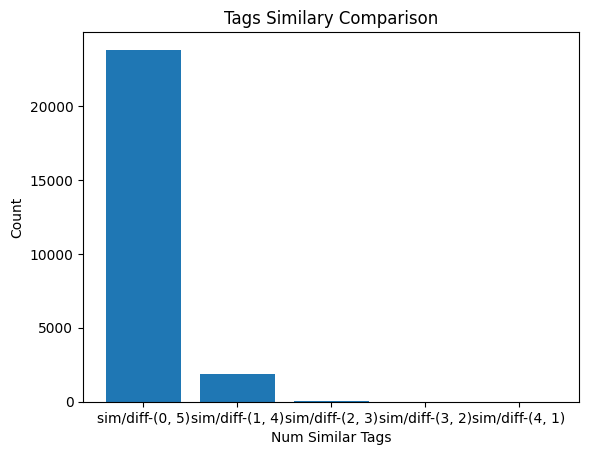

In [136]:
plot_bins(bins_dict)

In [140]:
NUM_COMPARISON_TAGS = 10
top_10_tags_tf_idf = get_top_tags_by(ROW_TF_IDF,num_tags=NUM_COMPARISON_TAGS)
top_10_tags_word2vec = get_top_tags_by(ROW_WORD2VEC,num_tags=NUM_COMPARISON_TAGS)

100%|██████████| 352/352 [01:23<00:00,  4.20it/s]

tags:  tf_idf | word2vec
0.  על | לצדק
1.  של | ישראל
2.  המשפט | פסק
3.  את | הישיבה
4.  כבוד | בע
5.  כי | ברק
6.  בית | המשיבים
7.  המערער | בת
8.  לא | צו
9.  עו"ד | ללא


In [142]:
compare_top_tags(top_10_tags_tf_idf,"tf_idf",top_10_tags_word2vec,"word2vec",NUM_COMPARISON_TAGS)

tags:  tf_idf | word2vec
0.  על | לצדק
1.  של | ישראל
2.  המשפט | פסק
3.  את | הישיבה
4.  כבוד | בע
5.  כי | ברק
6.  בית | המשיבים
7.  המערער | בת
8.  לא | צו
9.  עו"ד | ללא


In [198]:

# def trainWiki(inp = "./wiki.he.text",out_model = "wiki.he.word2vec.model"):
#     start = time.time()
#     model = Word2Vec(LineSentence(inp), sg = 1,
#                      vector_size=100, 
#                      window=5, 
#                      min_count=5, 
#                      workers=multiprocessing.cpu_count(),
#                      )
#     model.init_sims(replace=True)
#     print(time.time()-start)
#     model.save(out_model)

# def getWikiModel(model = "wiki.he.word2vec.model"):
#     model = Word2Vec.load(model)
#     return model




# def trainVerdicts(csv_files, out_model="verdicts.word2vec.model"):
#     start = time.time()

#     if os.path.exists(out_model):
#         model = Word2Vec.load(out_model)  # Load existing model
#     else:
#         model = Word2Vec(sg=1,
#                          vector_size=100,
#                          window=5,
#                          min_count=5,
#                          workers=multiprocessing.cpu_count())
        
#     for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
#         for index,row in batch.iterrows():
#             text = row['text']
            
#             try:  # Check if texts list is not empty
#                 if not model.wv.key_to_index:  # Check if vocabulary is empty
#                     model.build_vocab(ts)
#                 else:
#                     model.build_vocab_from_freq(model.wv.key_to_index)  # Update vocabulary based on existing words
                
#                 model.train(texts, total_examples=len(ts), epochs=model.epochs)
#             except Exception as e:
#                 print(e)
#                 pass

#     model.init_sims(replace=True)
#     model.save(out_model)
#     print(time.time() - start)

# def getVerdictsModel(model="verdicts.word2vec.model"):
#     model = Word2Vec.load(model)
#     return model

# trainVerdicts(csv_files)
    

In [199]:
# def trainVerdicts(csv_files, out_model="verdicts.word2vec.model"):
#     start = time.time()

#     if os.path.exists(out_model):
#         model = Word2Vec.load(out_model)  # Load existing model
#     else:
#         model = Word2Vec(sg=1,
#                          vector_size=100,
#                          window=5,
#                          min_count=5,
#                          workers=multiprocessing.cpu_count())

#     batch_size = 100  # Define the batch size

#     with tqdm(total=len(csv_files), desc="Training", position=0) as pbar:
#         for csv_file in csv_files:
#             df = pd.read_csv("./data/supreme/" + csv_file)
#             texts = df['text'].tolist()
#             pbar.set_postfix(file=csv_file)
#             pbar.update(1)

#             # Split texts into batches
#             num_batches = len(texts) // batch_size
#             remainder = len(texts) % batch_size

#             for i in range(num_batches):
#                 batch_texts = texts[i * batch_size: (i + 1) * batch_size]
#                 update_model(model, batch_texts)

#             if remainder > 0:
#                 batch_texts = texts[-remainder:]
#                 update_model(model, batch_texts)

#     model.init_sims(replace=True)
#     model.save(out_model)
#     print(time.time() - start)

# def update_model(model, texts):
#     if texts:  # Check if texts list is not empty
#         if not model.wv.key_to_index:  # Check if vocabulary is empty
#             model.build_vocab(texts, update=True)
#         else:
#             model.build_vocab_from_freq(model.wv.key_to_index, update=True)  # Update vocabulary based on existing words

#         model.train(texts, total_examples=len(texts), epochs=model.epochs)

# def getVerdictsModel(model="verdicts.word2vec.model"):
#     model = Word2Vec.load(model)
#     return model

# trainVerdicts(csv_files)


## 5. Dataset Statistics
    - In Certain TimeFrame:
    - a. Number of verdict of each judge
    - b. Number of verdicts each judge gave in the top 10 popular subject tags

In [201]:
start_date = "2004-01-01"
end_date = "2005-01-01"

In [212]:
def get_judge_names(first_names,last_names):
    first = first_names.strip('[ ]')
    first = first.replace("'", "")
    first = first.split(' ')
    last = last_names.strip('[ ]')
    last = last.replace("'", "")
    last = last.replace('"', "")
    last = last.split(' ')
    judge_names = [first[i] + " " + last[i] for i in range(len(first))]
    return judge_names


def get_date_from_string(dt):
    return datetime.datetime.strptime(dt,"%Y-%m-%d")

def is_in_date_range(start_date,end_date,date):
    start_date = get_date_from_string(start_date)
    end_date = get_date_from_string(end_date)
    date = get_date_from_string(date)
    if start_date <= date <= end_date:
        return True
    else:
        return False

In [223]:
def get_stats_v1(start_date,end_date,top_10_tags,col_name):
    top_tags_counts = {tag:0 for tag in top_10_tags}
    judges_num_verdicts = { }
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        for index,row in batch.iterrows():
            text = row['text']
            verdict_date = row['meta_verdict_dt']
            first = row['meta_judge_nm_first']
            last = row['meta_judge_nm_last']
            tags = str_list_to_list(row[f'{col_name}_tags'])
            is_in_range = is_in_date_range(start_date,end_date,verdict_date)
            if not is_in_range:
                continue
            judge_names = get_judge_names(first,last)
            for judge in judge_names:
                if judge not in judges_num_verdicts.keys():
                    judges_num_verdicts[judge] = 0
                judges_num_verdicts[judge] += 1

            for tag in tags:
                if tag in top_tags_counts.keys():
                    top_tags_counts[tag] += 1
                    
    return top_tags_counts,judges_num_verdicts

def print_stats_v1(title,start_date,end_date,top_tags_counts,judges_num_verdicts):
    print(f"-- {title} --")
    print('start date: ',start_date, "end date: ", end_date)
    print("in this timeframe:")
    print()
    print("top 10 tags:")
    for tag,count in top_tags_counts.items():
        print(f"{tag}:",count)
    print()
    print("judges number of verdicts:")
    for judge,num_vertics in judges_num_verdicts.items():
        print(f"{judge}:",num_vertics)


In [224]:
top_tags_counts1,judges_num_verdicts1 = get_stats_v1(start_date,end_date,top_10_tags_tf_idf,ROW_TF_IDF)

100%|██████████| 352/352 [01:14<00:00,  4.72it/s]


In [225]:
print_stats_v1("tf_idf tags",start_date,end_date,top_tags_counts1,judges_num_verdicts1)

-- tf_idf tags --
start date:  2004-01-01 end date:  2005-01-01
in this timeframe:

top 10 tags:
על: 2287
של: 2226
המשפט: 1504
את: 1714
כבוד: 1359
כי: 1488
בית: 443
המערער: 612
לא: 424
עו"ד: 365

judges number of verdicts:
דורית ביניש: 721
אילה פרוקציה: 512
סלים גובראן: 515
אהרן ברק: 636
תאודור אור: 110
אליהו מצא: 462
אדמונד לוי: 637
אשר גרוניס: 667
מרים נאור: 760
עדנה ארבל: 112
מישאל חשין: 425
אליעזר ריבלין: 570
אליקים רובינשטיין: 129
דליה דורנר: 137
יעקב טירקל: 233
אסתר חיות: 562
חגית מאק-קלמנוביץ: 115
אילה
 פרוקציה
: 3
יהונתן עדיאל: 332
יגאל מרזל: 3
טובה שטרסברג-כהן: 1
עודד שחם: 5
בעז אוקון: 2
שלמה לוין: 1


In [226]:
top_tags_counts2,judges_num_verdicts2 = get_stats_v1(start_date,end_date,top_10_tags_word2vec,ROW_WORD2VEC)

100%|██████████| 352/352 [01:29<00:00,  3.95it/s]


In [228]:
print_stats_v1("word2vec tags",start_date,end_date,top_tags_counts2,judges_num_verdicts2)

-- word2vec tags --
start date:  2004-01-01 end date:  2005-01-01
in this timeframe:

top 10 tags:
לצדק: 1067
ישראל: 857
פסק: 747
הישיבה: 692
בע: 633
ברק: 615
המשיבים: 395
בת: 379
צו: 342
ללא: 388

judges number of verdicts:
דורית ביניש: 721
אילה פרוקציה: 512
סלים גובראן: 515
אהרן ברק: 636
תאודור אור: 110
אליהו מצא: 462
אדמונד לוי: 637
אשר גרוניס: 667
מרים נאור: 760
עדנה ארבל: 112
מישאל חשין: 425
אליעזר ריבלין: 570
אליקים רובינשטיין: 129
דליה דורנר: 137
יעקב טירקל: 233
אסתר חיות: 562
חגית מאק-קלמנוביץ: 115
אילה
 פרוקציה
: 3
יהונתן עדיאל: 332
יגאל מרזל: 3
טובה שטרסברג-כהן: 1
עודד שחם: 5
בעז אוקון: 2
שלמה לוין: 1


## 6. Use RNN to perform NER recognision for dataset generation(2)

### RNN Model - LSTM

In [361]:
def get_raw_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    words = t.split(" ")
    words = [word.strip() for word in words if len(word.strip()) > 0]
    return words


def split_and_pad_string(input_string, chunk_size, padding_character):
    chunks = [input_string[i:i+chunk_size] for i in range(0, len(input_string), chunk_size)]
    last_chunk_length = len(chunks[-1])
    if padding_character:
        if last_chunk_length < chunk_size:
            chunks[-1] = chunks[-1].ljust(chunk_size, padding_character)
    return chunks


def get_sentences(text,size,padding_character=None):
    bag = get_raw_bag_of_words(text)
    text = ' '.join(bag)
    sentences = text.split(".")
    sentences = [s.strip() for s in sentences if len(s.strip()) > 1]
    sentences = [s.strip()[:len(s)- 1].strip() if s[len(s) - 1].isdigit() else s for s in sentences]
    sentences = [s.strip() for s in sentences if len(s.strip()) > size]
    sentences = [split_and_pad_string(s,size,padding_character) for s in sentences]

    combined_list_sentences = []
    for sen in sentences:
        combined_list_sentences.extend(sen)
    return combined_list_sentences
    


def replace_pattern_to_ner_label(text,ner_label,multi_word_expression:str,reverse=True):
    expression = multi_word_expression
    new_text = text
    label_text = " "
    num_words_in_expression = len(expression.split(" "))
    for word in range(num_words_in_expression):
        label_text += ner_label + " "
    label_text = label_text.strip()
    

    pattern = re.compile(r"\b" + re.escape(expression) + r"\b")
    modified_text = re.sub(pattern,label_text,new_text)
    if modified_text != text:
        return modified_text        
    if reverse:
        reverse_pattern = re.compile(r"\b" + re.escape(reverse_words_order(expression)) + r"\b")
        reverse_modified_text = re.sub(reverse_pattern, label_text, text)
        if reverse_modified_text != text:
            return reverse_modified_text
    return new_text


def replace_patterns_to_ner_label(text,ner_label,expressions):
    new_text = text
    if isinstance(expressions,list):
        for expressions in expressions:
            new_text = replace_pattern_to_ner_label(new_text,ner_label,expressions)
        return new_text
    if isinstance(expressions,str):
        new_text =  replace_pattern_to_ner_label(new_text,ner_label,expressions)
        return new_text
    return new_text


In [ ]:
filename = item['filename']
procedures = item['procedures']
first_names = item['judge_first_names']
last_names = item['judge_last_names']
judge_genders = item['judges_genders']
team_one_names = item['team_one_names']
team_one = item['team_one']
team_one_extra = item['team_one']
team_one_lawyers_teams_names = item['team_one_lawyers_teams_names']
team_one_lawyers = item['team_one_lawyers']
team_two_names = item['team_two_names']
team_two = item['team_two']
team_two_extra = item['team_two']
team_two_lawyers_teams_names = item['team_two_lawyers_teams_names']
team_two_lawyers = item['team_two_lawyers']
date = item['date']
lawyers_teams = item['all_lawyers_teams_names']
lawyers = item['all_lawyers']
text = item['text']






In [ ]:
def string_to_list(lst_str:str):
    return lst_str.split("|")

def string_to_nested_list(lst_str:str):
    lst = []
    for item in lst_str.split("@"):
        lst.append(string_to_list(item))
    return lst


In [ ]:
class MyDataset(Dataset):
    NER_LAWYER = "LAWYER"
    NER_JUDGE = "JUDGE"
    NER_CASE = "CASE" 
    NER_PROCEDURE = "PROCEDURE"
    NER_DEFENSE_PARTY = "DEFENSE_TITLE"
    NER_DEFENSE_PARTY = "DEFENSE_PARTY"
    NER_DEFENSE_LAWYER = "DEFENSE_LAWYER"
    NER_PROSECUTION_TITLE = "PROSECUTION_TITLE"
    NER_PROSECUTION_PARTY = "PROSECUTION_PARTY"
    NER_PROSECUTION_LAWYER = "PROSECUTION_LAWYER"
    NER_VERDICT_DATE = "DATE"
    NER_OTHER = "O"
    NERS = [
        NER_LAWYER,
        NER_JUDGE,
        NER_CASE,
        NER_PROCEDURE,
        NER_DEFENSE_PARTY,
        NER_DEFENSE_PARTY,
        NER_DEFENSE_LAWYER,
        NER_PROSECUTION_TITLE,
        NER_PROSECUTION_PARTY,
        NER_PROSECUTION_LAWYER,
        NER_VERDICT_DATE,
        NER_OTHER,
    ]
    
    def __init__(self,max_len:int) -> None:
        self.max_len = max_len 
        self.queries = queries
        self.padd_char = " "
    
    def __len__(self):
        return len(self.queries)

    def handle_data(self,item):
        filename = item['filename']
        procedures = item['procedures']
        first_names = item['judge_first_names']
        last_names = item['judge_last_names']
        judge_genders = item['judges_genders']
        team_one_names = item['team_one_names']
        team_one = item['team_one']
        team_one_extra = item['team_one']
        team_one_lawyers_teams_names = item['team_one_lawyers_teams_names']
        team_one_lawyers = item['team_one_lawyers']
        team_two_names = item['team_two_names']
        team_two = item['team_two']
        team_two_extra = item['team_two']
        team_two_lawyers_teams_names = item['team_two_lawyers_teams_names']
        team_two_lawyers = item['team_two_lawyers']
        date = item['date']
        lawyers_teams = item['all_lawyers_teams_names']
        lawyers = item['all_lawyers']
        text = item['text']
        last = string_to_list(last_names)
        first = string_to_list(first_names)
        genders = string_to_list(judge_genders)


        judges = [last[i] +"' "+ first[i] for i in range(len(first))]        
        verdict_procedures = string_to_list(procedures)
        team_one_represent = string_to_list(team_one_lawyers_teams_names)
        team_one_represent_lawyers = string_to_nested_list(team_one_lawyers)
        team_two_represent = string_to_list(team_two_lawyers_teams_names)
        team_two_represent_lawyers = string_to_nested_list(team_two_lawyers)
        return (
            judges,
            verdict_procedures,
            team_one_represent,
            team_one_represent_lawyers,
            team_two_represent,
            team_two_represent_lawyers
        )



    def __getitem__(self, index):
        all_sentences = []
        for i,batch in tqdm(enumerate(data_gen()),total=len(queries)):
            for index,row in batch.iterrows():
                text = row['text']
                text_sentences = get_sentences(text,self.max_len, self.padd_char)
                (
                    judges,
                    verdict_procedures,
                    team_one_represent,
                    team_one_represent_lawyers,
                    team_two_represent,
                    team_two_represent_lawyers

                ) = self.handle_data(row)
                
                for sentence in text_sentences:
                    for t in team_one_represent:
                        replace_pattern_to_ner_label()


max_len = 25
padd_char = " "




In [ ]:

data_gen()

In [308]:
my_idf_dict = get_idf_dict(data_gen,queries)
my_idf_dict

100%|██████████| 36/36 [00:10<00:00,  3.30it/s]


{'של': 155382,
 'על': 106273,
 'כי': 106234,
 'את': 95541,
 'לא': 49621,
 'בית': 38563,
 'זה': 36848,
 'המשפט': 36621,
 'המערער': 36259,
 'או': 28291,
 'גם': 26630,
 'זו': 23115,
 'הוא': 22165,
 'אשר': 21564,
 'אין': 21129,
 'בין': 20967,
 'הדין': 19808,
 'היא': 19458,
 'כך': 19311,
 'יש': 17893,
 'סעיף': 17788,
 'אם': 17777,
 'להלן': 17384,
 'לחוק': 16972,
 'עם': 16890,
 'כל': 16193,
 'זאת': 16069,
 'כן': 15098,
 'פסקה': 14387,
 'ניתן': 14184,
 'היה': 14044,
 'השופט': 13921,
 'משפט': 13859,
 'ראו': 13764,
 'אף': 13395,
 'המחוזי': 13006,
 'עניין': 12477,
 'לאחר': 12327,
 'ישראל': 11895,
 'באופן': 11097,
 'המשיב': 11037,
 'כדי': 10982,
 'ידי': 10867,
 'שלא': 10157,
 'בעניין': 9899,
 'לפי': 9893,
 'בו': 9883,
 'אינו': 9625,
 'אינה': 9419,
 'ביחס': 9272,
 'כאמור': 9266,
 'לו': 9174,
 'במסגרת': 8999,
 'לכך': 8858,
 'אלה': 8818,
 'כאשר': 8694,
 'כפי': 8666,
 'ביום': 8662,
 'מדובר': 8557,
 'אלא': 8431,
 'עוד': 8283,
 'ולא': 8226,
 'דין': 8175,
 'חוק': 8167,
 'מקום': 8006,
 'אך': 7867,
 'פסק'

In [311]:
from datasets import load_dataset
conll_data = load_dataset("conll2003")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /home/yuval/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

class Sentances(Dataset):
    def __init__(self) -> None:
        pass


In [309]:
class Vocabulary():
    def __init__(self,words=[]) -> None:
        self.words = words

    def __len__(self):
        return len(self.words)
    
    
a = Vocabulary()
len(a)

3

In [245]:
MAX_LENGTH = 1000
MAX_WORDS = 1000
vocab = list(set(list(idf_dict.keys())))
len(vocab)

346601

In [247]:
replace_patterns_to_ner_label("hey hey ","NER", ["ye","hello","hey"])

'NER NER '

In [ ]:

class VerdictsBatchesDataset(Dataset):
    NER_JUDGE_FIRST_NAME = "JUDGE_FIRST"
    NER_JUDGE_LAST_NAME = "JUDGE_LAST"
    NER_LAWYER_FIRST_NAME = "LAWYER_FIRST"
    NER_LAWYER_LAST_NAME = "LAWYER_LAST"
    NER_LAWYER = "LAWYER"
    NER_JUDGE = "JUDGE"
    NER_CASE = "CASE" 
    NER_CASE_ID = "CASE"
    NER_DEFENSE_PARTY = "DEFENSE"
    NER_PROSECUTION_PARTY = "PROSECUTION"
    NER_VERDICT_DATE = "DATE"
    NER_OTHER = "O"
    
    PROSECUTION = "תביעה"
    DEFENSE = "הגנה"

    NERS = [
        NER_JUDGE_FIRST_NAME,
        NER_JUDGE_LAST_NAME,
        NER_LAWYER_FIRST_NAME,
        NER_LAWYER_LAST_NAME,
        NER_LAWYER,
        NER_JUDGE,
        NER_CASE,
        NER_CASE_ID,
        NER_DEFENSE_PARTY,
        NER_PROSECUTION_PARTY,
        NER_VERDICT_DATE,
        NER_WHITE_SPACE,
        NER_OTHER,
    ]

    def __init__(self,csv_files,vocab,max_words,max_length) -> None:

        self.pathes = []
        for csv_file in csv_files:
            self.pathes.append(os.path.join(batch_directory,csv_file))
        self.max_words = max_words
        self.max_length = max_length
        self.vocab = vocab
        self.word_to_index = {token: index+1 for index, token in enumerate(self.vocab)}
        self.index_to_word = {index+1: token for index, token in enumerate(self.vocab)}        

        
    def __len__(self):
        return len(self.pathes)
    

    def replace_text_to_labels(self,sentence,row):
        row = row.fillna("[]")
        text = row['text']
        new_text = text
        if sentence:
            new_text = sentence
        judges = super_string_list_to_list(row['meta_judge'])
        lawyers = super_string_list_to_list(row['meta_lawyer_nm'])
        case_names = row['meta_case_nm']
        verdict_date = row['meta_verdict_dt']
        cases_text_id = row['meta_case_nbr']
        side_parties = super_string_list_to_list(row['meta_side_nm'])
        side_parties_types_labels = super_string_list_to_list(row['meta_side_ty'])

        

        length = min(len(side_parties_types_labels),len(side_parties))
        for i in range(length):
            side_party_type = side_parties_types_labels[i]
            side_party = side_parties[i]
            if self.DEFENSE in side_party_type:
                new_text = replace_patterns_to_ner_label(new_text,self.NER_DEFENSE_PARTY,side_party)
                continue
            if self.PROSECUTION in side_party_type:
                new_text = replace_patterns_to_ner_label(new_text,self.NER_PROSECUTION_PARTY,side_party)
                continue

        
        new_text = replace_patterns_to_ner_label(new_text,self.NER_JUDGE,judges)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_LAWYER,lawyers)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_CASE,case_names)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_VERDICT_DATE,verdict_date)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_CASE_ID,cases_text_id)

        bag = get_unordered_bag_of_words(new_text)
        
        for i,token in enumerate(bag):
            if token not in self.NERS:
                bag[i] = self.NER_OTHER

        return bag
        # new_text = ' '.join(bag)
        # return new_text
    

    def bag_to_indexes(self,word_bag:list[str]) -> list[int]:
        indexes = []
        for word in word_bag:
            if word not in self.word_to_index:
                indexes.append(-1)
                continue
            index = self.word_to_index[word]
            indexes.append(index)
        return indexes

    def indexes_to_bag(self,indexes:list[int]) -> list[str]:
        words = []
        for index in indexes:
            if index == -1:
                words.append(" ")
            else:
                word = self.index_to_word[index]
                words.append(word)
        return words
    
    
    def ner_to_index(self,ner_label):
        for i , label in enumerate(self.NERS):
            if label == ner_label:
                return i

    def ners_to_indexes(self,ners):
        indexes = []
        for ner in ners:
            indexes.append(self.ner_to_index(ner))
        return indexes


    # def __getitem__(self, index):
    #     path = self.pathes[index]
    #     batch_df = pd.read_csv(path)
    #     ner_labels = []
    #     verdicts = batch_df['text']
    #     for index,row in batch_df.iterrows():
    #         label = self.get_labels(row)
    #         ner_labels.append(label)
    #     return verdicts,ner_labels

    def __getitem__(self, index):
        path = self.pathes[index]
        batch_df = pd.read_csv(path)
        # ner_labels = []
        # verdicts = batch_df['text'].tolist()
        
        # encoded_texts = []
        # for v in verdicts:
        #     b = get_unordered_bag_of_words(v)
        #     encoded = self.bag_to_indexes(b)
        #     encoded_texts.append(encoded)

        all_sentences = []
        for _, row in batch_df.iterrows():
            text = row['text']
            max_len = 50
            sentences = get_sentences(text,max_len)
            for s in sentences:
                ners = self.replace_text_to_labels(s,row)
                bag = get_unordered_bag_of_words(s)
                index_bag = self.bag_to_indexes(bag)
                ners_indexes = self.ners_to_indexes(ners)
                all_sentences.append((s,bag,index_bag,ners,ners_indexes))


            # X = [[word2idx[w[0]] for w in s] for s in sentences]
            # X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(vocab)- 1)

            # y = [[tag2idx[w[1]] for w in s] for s in sentences]
            # y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=self.NERS.index("O"))            
            


            # new_text = self.replace_text_to_labels(,row)

            # ner_labels.append(label)
    

        return all_sentences
        # return encoded_texts,ner_labels
        # verdicts_tensor = torch.tensor(indexed_verdicts, dtype=torch.long)
        # ner_labels_array = np.array(ner_labels, dtype=object)
        # ner_labels_tensor = torch.from_numpy(ner_labels_array)

        # return verdicts_tensor, ner_labels_tensor

classes = VerdictsBatchesDataset.NERS

data = VerdictsBatchesDataset(csv_files=csv_files,vocab=vocab,max_words=MAX_WORDS,max_length=MAX_LENGTH)




In [ ]:
import dataclasses

@dataclasses.dataclass

class Tag:
    id:int
    name:str
    tag:str




In [377]:

class VerdictsBatchesDataset(Dataset):
    NER_LAWYER = "LAWYER"
    NER_JUDGE = "JUDGE"
    NER_CASE = "CASE" 
    NER_CASE_ID = "CASE"
    NER_DEFENSE_PARTY = "DEFENSE"
    NER_PROSECUTION_PARTY = "PROSECUTION"
    NER_VERDICT_DATE = "DATE"
    NER_OTHER = "O"
    NER_WHITE_SPACE = "WHITESPACE"
    
    PROSECUTION = "תביעה"
    DEFENSE = "הגנה"

    NERS = [
        NER_LAWYER,
        NER_JUDGE,
        NER_CASE,
        NER_CASE_ID,
        NER_DEFENSE_PARTY,
        NER_PROSECUTION_PARTY,
        NER_VERDICT_DATE,
        NER_WHITE_SPACE,
        NER_OTHER,
    ]

    def __init__(self,csv_files,vocab,max_words,max_length) -> None:

        self.pathes = []
        for csv_file in csv_files:
            self.pathes.append(os.path.join(batch_directory,csv_file))
        self.max_words = max_words
        self.max_length = max_length
        self.vocab = vocab
        self.word_to_index = {token: index+1 for index, token in enumerate(self.vocab)}
        self.index_to_word = {index+1: token for index, token in enumerate(self.vocab)}        

        
    def __len__(self):
        return len(self.pathes)
    

    def replace_text_to_labels(self,sentence,row):
        row = row.fillna("[]")
        text = row['text']
        new_text = text
        if sentence:
            new_text = sentence
        judges = super_string_list_to_list(row['meta_judge'])
        lawyers = super_string_list_to_list(row['meta_lawyer_nm'])
        case_names = row['meta_case_nm']
        verdict_date = row['meta_verdict_dt']
        cases_text_id = row['meta_case_nbr']
        side_parties = super_string_list_to_list(row['meta_side_nm'])
        side_parties_types_labels = super_string_list_to_list(row['meta_side_ty'])

    
        length = min(len(side_parties_types_labels),len(side_parties))
        for i in range(length):
            side_party_type = side_parties_types_labels[i]
            side_party = side_parties[i]
            if self.DEFENSE in side_party_type:
                new_text = replace_patterns_to_ner_label(new_text,self.NER_DEFENSE_PARTY,side_party)
                continue
            if self.PROSECUTION in side_party_type:
                new_text = replace_patterns_to_ner_label(new_text,self.NER_PROSECUTION_PARTY,side_party)
                continue

        
        new_text = replace_patterns_to_ner_label(new_text,self.NER_JUDGE,judges)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_LAWYER,lawyers)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_CASE,case_names)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_VERDICT_DATE,verdict_date)
        new_text = replace_patterns_to_ner_label(new_text,self.NER_CASE_ID,cases_text_id)

        bag = get_unordered_bag_of_words(new_text)
        
        for i,token in enumerate(bag):
            if token not in self.NERS:
                bag[i] = self.NER_OTHER

        return bag


    def bag_to_indexes(self,word_bag:list[str]) -> list[int]:
        indexes = []
        for word in word_bag:
            if word not in self.word_to_index:
                indexes.append(-1)
                continue
            index = self.word_to_index[word]
            indexes.append(index)
        return indexes

    def indexes_to_bag(self,indexes:list[int]) -> list[str]:
        words = []
        for index in indexes:
            if index == -1:
                words.append(" ")
            else:
                word = self.index_to_word[index]
                words.append(word)
        return words
    
    
    def ner_to_index(self,ner_label):
        for i , label in enumerate(self.NERS):
            if label == ner_label:
                return i

    def ners_to_indexes(self,ners):
        indexes = []
        for ner in ners:
            indexes.append(self.ner_to_index(ner))
        return indexes

    def __getitem__(self, index):
        path = self.pathes[index]
        batch_df = pd.read_csv(path)

        all_sentences = []
        for _, row in batch_df.iterrows():
            text = row['text']
            max_len = 50
            sentences = get_sentences(text,max_len)
            for s in sentences:
                ners = self.replace_text_to_labels(s,row)
                bag = get_unordered_bag_of_words(s)
                index_bag = self.bag_to_indexes(bag)
                ners_indexes = self.ners_to_indexes(ners)
                all_sentences.append((s,bag,index_bag,ners,ners_indexes))
    
        return all_sentences
    
classes = VerdictsBatchesDataset.NERS

data = VerdictsBatchesDataset(csv_files=csv_files,vocab=vocab,max_words=MAX_WORDS,max_length=MAX_LENGTH)




In [ ]:
# from itertools import chain
# def get_dict_map(data, token_or_tag):
#     tok2idx = {}
#     idx2tok = {}
    
#     if token_or_tag == 'token':
#         vocab = list(set(data['Word'].to_list()))
#     else:
#         vocab = list(set(data['Tag'].to_list()))
    
#     idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
#     tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
#     return tok2idx, idx2tok


# token2idx, idx2token = get_dict_map(data, 'token')
# tag2idx, idx2tag = get_dict_map(data, 'tag')

In [364]:
d = data[0]
print(len(d))   
d

20363


[('בבית המשפט העליון בשבתו כבית משפט גבוה לצדק בג"ץ 1',
  ['בבית',
   'המשפט',
   'העליון',
   'בשבתו',
   'כבית',
   'משפט',
   'גבוה',
   'לצדק',
   'בג"ץ',
   '1'],
  [12031, 177461, 91884, 249193, 112110, 274395, 98368, 106440, 187327, -1],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
  [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 ("0820/03 בפני: כבוד השופטת ד' ביניש כבוד השופטת א' ",
  ['082003', 'בפני', 'כבוד', 'השופטת', "ד'", 'ביניש', 'כבוד', 'השופטת', "א'"],
  [-1, 160848, 182919, 25961, -1, 9718, 182919, 25961, -1],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
  [12, 12, 12, 12, 12, 12, 12, 12, 12]),
 ("פרוקצ'יה כבוד השופט ס' ג'ובראן העותרים:",
  ["פרוקצ'יה", 'כבוד', 'השופט', "ס'", "ג'ובראן", 'העותרים'],
  [-1, 182919, 210727, -1, -1, 203463],
  ['O', 'O', 'O', 'O', 'O', 'O'],
  [12, 12, 12, 12, 12, 12]),
 ('השר הממונה על ביצוע חוק רשות השידור עתירה למתן צו ',
  ['השר',
   'הממונה',
   'על',
   'ביצוע',
   'חוק',
   'רשות',
   'השידור',
   'עתירה',
   'למתן',
   'צ

In [365]:
input_ner = [i[2] for i in d]
ner_labels = [i[4] for i in d]
print(len(input_ner),len(ner_labels))

20363 20363


In [366]:
for i in range(len(input_ner)):
    for j in range(len(input_ner[i])):
        if input_ner[i][j] == -1:
            input_ner[i][j] = 0

In [367]:
max_x = -1
for j in range(len(input_ner)):
    if max_x < len(input_ner[j]):
        max_x = len(input_ner[j])
print(max_x)

25


In [368]:
max_y = -1
for j in range(len(ner_labels)):
    if max_y < len(ner_labels[j]):
        max_y = len(ner_labels[j])
print(max_y)

25


In [369]:
x = pad_sequences(maxlen=max_x,sequences=input_ner, padding="post",value=10000)
y = pad_sequences(maxlen=max_y, sequences=ner_labels, padding="post", value=0)
print("x shape:",x.shape)
print("y shape:",y.shape)

x shape: (20363, 25)
y shape: (20363, 25)


In [394]:
conll_data = load_dataset("conll2003")

Using the latest cached version of the module from /home/yuval/.cache/huggingface/modules/datasets_modules/datasets/conll2003/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98 (last modified on Tue Jul 11 16:52:35 2023) since it couldn't be found locally at conll2003., or remotely on the Hugging Face Hub.
Found cached dataset conll2003 (/home/yuval/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_tags"]
            tokens = record["tokens"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )


os.mkdir("data")
export_to_file("./data/conll_train.txt", conll_data["train"])
export_to_file("./data/conll_val.txt", conll_data["validation"])

In [393]:


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
Next, let's define a `TokenAndPositionEmbedding` layer:
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings


"""
## Build the NER model class as a `keras.Model` subclass
"""


class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x


"""
## Load the CoNLL 2003 dataset from the datasets library and process it
"""



"""
We will export this data to a tab-separated file format which will be easy to read as a
`tf.data.Dataset` object.
"""




"""
## Make the NER label lookup table

NER labels are usually provided in IOB, IOB2 or IOBES formats. Checkout this link for
more information:
[Wikipedia](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))

Note that we start our label numbering from 1 since 0 will be reserved for padding. We
have a total of 10 labels: 9 from the NER dataset and one for padding.
"""


def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))


mapping = make_tag_lookup_table()
print(mapping)

"""
Get a list of all tokens in the training dataset. This will be used to create the
vocabulary.
"""

all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

"""
Create 2 new `Dataset` objects from the training and validation data
"""

train_data = tf.data.TextLineDataset("./data/conll_train.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

"""
Print out one line to make sure it looks good. The first record in the line is the number of tokens. 
After that we will have all the tokens followed by all the ner tags.
"""

print(list(train_data.take(1).as_numpy_iterator()))

"""
We will be using the following map function to transform the data in the dataset:
"""


def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)


# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

"""
We will be using a custom loss function that will ignore the loss from padded tokens.
"""


class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

"""
## Compile and fit the model
"""

ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)


def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)


# Sample inference using the trained model
sample_input = tokenize_and_convert_to_ids(
    "eu rejects german call to boycott british lamb"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)

"""
## Metrics calculation

Here is a function to calculate the metrics. The function calculates F1 score for the
overall NER dataset as well as individual scores for each NER tag.
"""


def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]
    print(predicted_tags,"\n",real_tags)
    #evaluate(real_tags, predicted_tags)


calculate_metrics(val_dataset)

"""
## Conclusions

In this exercise, we created a simple transformer based named entity recognition model.
We trained it on the CoNLL 2003 shared task data and got an overall F1 score of around 70%.
State of the art NER models fine-tuned on pretrained models such as BERT or ELECTRA can easily
get much higher F1 score -between 90-95% on this dataset owing to the inherent knowledge
of words as part of the pretraining process and the usage of subword tokenization.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/ner-with-transformers)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/ner_with_transformers)."""

Found cached dataset conll2003 (/home/yuval/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

FileExistsError: [Errno 17] File exists: 'data'

In [279]:
print(y)

[[12 12 12 ...  0  0  0]
 [12 12 12 ...  0  0  0]
 [12 12 12 ...  0  0  0]
 ...
 [12 12 12 ...  0  0  0]
 [12 12 12 ...  0  0  0]
 [12  0  0 ...  0  0  0]]


In [370]:
model = Sequential()
model.add(Embedding(input_dim=25, output_dim=32, input_length=25))
model.add(tensorflow.keras.layers.SpatialDropout1D(0.1))
model.add(tensorflow.keras.layers.Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1)))
model.add(tensorflow.keras.layers.TimeDistributed(Dense(10, activation='softmax')))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 32)            800       
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 25, 32)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 25, 200)          106400    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 25, 10)           2010      
 tributed)                                                       
                                                                 
Total params: 109,210
Trainable params: 109,210
Non-trainable params: 0
________________________________________________

In [371]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [380]:
from tensorflow.keras import layers
from tensorflow import keras


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings
    
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

In [379]:
def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = VerdictsBatchesDataset.NERS
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))

mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'O', 2: 'B-LAWYER', 3: 'I-LAWYER', 4: 'B-JUDGE', 5: 'I-JUDGE', 6: 'B-CASE', 7: 'I-CASE', 8: 'B-CASE', 9: 'I-CASE', 10: 'B-DEFENSE', 11: 'I-DEFENSE', 12: 'B-PROSECUTION', 13: 'I-PROSECUTION', 14: 'B-DATE', 15: 'I-DATE', 16: 'B-WHITESPACE', 17: 'I-WHITESPACE', 18: 'B-O', 19: 'I-O'}


In [383]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)

In [384]:
all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(
    vocabulary=vocabulary
)
train_data = tf.data.TextLineDataset("./data/conll_train.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

21009


In [385]:
batch_size = 1
train_dataset = (
    train_data.map(map_record_to_training_data)
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

In [386]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

In [387]:
ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)


def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)


# Sample inference using the trained model
sample_input = tokenize_and_convert_to_ids(
    "eu rejects german call to boycott british lamb"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)


Epoch 1/10


2023-07-11 18:37:41.400470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-11 18:37:41.400774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
/home/yuval/.local/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-11 18:3

UnimplementedError: Graph execution error:

Detected at node 'ner_model/token_and_position_embedding/embedding_4/Cast' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/yuval/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/yuval/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_275965/3559616724.py", line 2, in <module>
      ner_model.fit(train_dataset, epochs=10)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_275965/3927157783.py", line 58, in call
      x = self.embedding_layer(inputs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_275965/3927157783.py", line 42, in call
      token_embeddings = self.token_emb(inputs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/layers/core/embedding.py", line 223, in call
      inputs = tf.cast(inputs, "int32")
Node: 'ner_model/token_and_position_embedding/embedding_4/Cast'
Cast string to int32 is not supported
	 [[{{node ner_model/token_and_position_embedding/embedding_4/Cast}}]] [Op:__inference_train_function_20812]

In [ ]:
def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)


calculate_metrics(val_dataset)

In [372]:
model.fit(padded_sequences,np.zeros(len(padded_sequences)) , epochs=50, verbose=0)

ValueError: in user code:

    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 25), found shape=(None, 7)


In [289]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback


chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x,
    y=y,
    validation_data=(x,y),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3


2023-07-11 15:49:58.629969: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: indices[0,0] = 242867 is not in [0, 25)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/yuval/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/yuval/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/yuval/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/yuval/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_275965/412134823.py", line 11, in <module>
      history = model.fit(
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/yuval/.local/lib/python3.10/site-packages/keras/layers/core/embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_2/embedding_2/embedding_lookup'
indices[0,0] = 242867 is not in [0, 25)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]] [Op:__inference_train_function_16286]

In [ ]:
train_loader = DataLoader(data,batch_size=1,shuffle=True)
for i, sentences in tqdm(enumerate(train_loader),total=len(train_loader)):
    pass

#     return (word,tag)
# word2idx = {w: i + 1 for i, w in enumerate(vocab)}
# tag2idx = {t: i for i, t in enumerate(classes)}

# sentences = get_sentences(t,20)
# sentences = [get_label(s) for s in sentences]

# max_len = 50

# X = [[word2idx[w[0]] for w in s] for s in sentences]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# y = [[tag2idx[w[2]] for w in s] for s in sentences]
# y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])



In [75]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [65]:
tokenizer.word_index

{'י': 1,
 'ו': 2,
 'ה': 3,
 'ל': 4,
 'ב': 5,
 'ר': 6,
 'ת': 7,
 'ש': 8,
 'מ': 9,
 'נ': 10,
 'ע': 11,
 'א': 12,
 'ד': 13,
 'ט': 14,
 'פ': 15,
 'ם': 16,
 'ק': 17,
 'כ': 18,
 'ח': 19,
 'ן': 20,
 'ג': 21,
 'צ': 22,
 'ס': 23,
 'ז': 24,
 'ך': 25,
 'ף': 26,
 "'": 27,
 'ץ': 28,
 '\u200f': 29}

In [66]:
from tensorflow.keras.layers import TextVectorization
text_vector_layer = TextVectorization(
    max_tokens=None,
    standardize='strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8'
)

In [252]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_t = ' '.join(get_bag_of_words(example_verdict_batch['text'][0])) 
test_t = ' '.join(get_bag_of_words(example_verdict_batch['text'][1])) 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_t)
sequences = tokenizer.texts_to_sequences(train_t)
print(sequences)
TextVectorization()
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length))
model.add(SimpleRNN(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(padded_sequences,np.zeros(len(padded_sequences)) , epochs=50, verbose=0)
test_sequences = tokenizer.texts_to_sequences(test_t)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')
model.predict(test_padded_sequences)

NameError: name 'example_verdict_batch' is not defined

ValueError: Data cardinality is ambiguous:
  x sizes: 3564
  y sizes: 6
Make sure all arrays contain the same number of samples.

In [253]:

text_data = [
    "I love coding",
    "Coding is fun",
    "Python is my favorite language",
    "I want to learn more about NLP",
    "Deep learning is exciting",
    "I enjoy working with neural networks"
]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length))
model.add(SimpleRNN(16))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
for i in padded_sequences:
    print(len(i))

model.fit(padded_sequences, np.array([1,1,1,0,0,0]), epochs=50, verbose=0)

test_data = [
    "I hate programming",
    "NLP is boring",
    "Recurrent neural networks are cool"
]
test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')
model.predict(test_padded_sequences)

7
7
7
7
7
7
1/1 [==============================] - 0s 105ms/step


array([[0.6904821 ],
       [0.82915723],
       [0.19089413]], dtype=float32)

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
text_data = [
    "I love coding",
    "Coding is fun",
    "Python is my favorite language",
    "I want to learn more about NLP",
    "Deep learning is exciting",
    "I enjoy working with neural networks"
]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(padded_sequences, np.array([1,1,1,0,0,0]), epochs=50, verbose=0)
test_data = [
    "I hate programming",
    "NLP is boring",
    "Recurrent neural networks are cool"
]
test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')
model.predict(test_padded_sequences)

2023-07-08 01:35:32.121788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 01:35:32.122984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 01:35:32.123846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 222ms/step


2023-07-08 01:35:33.627445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 01:35:33.628713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 01:35:33.629720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

array([[0.69550127],
       [0.7166688 ],
       [0.60972023]], dtype=float32)

In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        output, _ = self.lstm(embedded)
        output = self.fc(output)
        return output


In [90]:
import re

def sentiment_analysis(text):
    # Define the sentiment rules
    positive_words = ['good', 'great', 'excellent']
    negative_words = ['bad', 'terrible', 'awful']

    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize the text
    tokens = text.split()

    # Initialize sentiment score
    sentiment_score = 0

    # Check for positive and negative words
    for token in tokens:
        if token in positive_words:
            sentiment_score += 1
        elif token in negative_words:
            sentiment_score -= 1

    # Classify sentiment based on sentiment score
    if sentiment_score > 0:
        sentiment = 'Positive'
    elif sentiment_score < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment

# Example usage
text1 = "I had a great time at the party!"
text2 = "The movie was awful, I didn't like it at all."
text3 = "The weather is neither good nor bad."

sentiment1 = sentiment_analysis(text1)
sentiment2 = sentiment_analysis(text2)
sentiment3 = sentiment_analysis(text3)

print("Text 1 Sentiment:", sentiment1)
print("Text 2 Sentiment:", sentiment2)
print("Text 3 Sentiment:", sentiment3)

Text 1 Sentiment: Positive
Text 2 Sentiment: Negative
Text 3 Sentiment: Neutral


In [65]:
def custom_collate(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return inputs, labels

def train(model, dataset, num_epochs, learning_rate, batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()

            inputs = [item.squeeze(0) for item in inputs]  # Remove the extra dimension
            inputs = torch.stack(inputs, dim=0)
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)

            outputs = model(inputs)
            loss = criterion(outputs.permute(0, 2, 1), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")


In [74]:
input_size = len(data.NERS)  # Vocabulary size
hidden_size = 128
output_size = len(data.NERS)
num_epochs = 10
learning_rate = 0.001
batch_size = 8

model = LSTMModel(input_size, hidden_size, output_size).to(device)
train(model, data, num_epochs, learning_rate, batch_size)


ValueError: expected sequence of length 4462 at dim 1 (got 236)

In [ ]:



# Step 2: Prepare the Labels
# Assuming you have labeled entities in each verdict

# Step 4: Define the RNN Model
num_words = 10000  # Define the maximum number of words to consider in the vocabulary
embedding_dim = 100
max_length = 1000  # Define the maximum sequence length
num_labels = 10  # Define the number of labels

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dense(units=num_labels, activation='softmax'))

# Step 5: Train the Model
batch_size = 1
num_epochs = 10

# Split the dataset into training and testing sets

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
for file in data_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    
    batch_verdicts = df['text_column'].tolist()
    
    # Tokenize the text verdicts and convert them to numerical sequences
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(batch_verdicts)
    sequences = tokenizer.texts_to_sequences(batch_verdicts)

    # Pad the sequences to make them uniform in length
    padded_sequences = pad_sequences(sequences, maxlen=max_length)

    # Prepare the labels for this batch

    # Train the model on the current batch
    model.fit(padded_sequences, batch_labels, batch_size=batch_size, epochs=num_epochs)

# Step 6: Evaluate the Model
# Evaluate the model on the test set

# Step 7: Fine-tune and Improve
# Perform fine-tuning by adjusting hyperparameters, adding regularization, or trying different architectures


In [ ]:
class VerdictsDataset(tensorflow.keras.utils.Sequence):

    def __init__(self,csv_files) -> None:
        self.pathes = []
        for csv_file in csv_files:
            self.pathes.append(os.path.join(batch_directory, csv_file))

    def __len__(self):
        pass



for 



        


In [ ]:
def get_bilstm_lstm_model():
    output_dim = 64
    model = Sequential()
    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

In [3]:
# nlp = spacy.load("./he_ner_news_trf-3.2.1-py3-none-any/he_ner_news_trf/he_ner_news_trf-3.2.1")
# doc = nlp("מה הולך אדון אלון")
# for entity in doc.ents:
#     print(f"{entity.text} \t {entity.label_}: {entity._.confidence_score:.4f} ({entity.start_char},{entity.end_char})")

אלון 	 PERS: 0.9996 (13,17)


In [22]:
b = pd.read_csv('./data/supreme/verdict_batch_0.csv')
v = b.iloc[1]['text']
d = nlp(v)
labels = []
for entity in d.ents:
    if entity.label_ == 'ORG':
        labels.append(entity.text)
    print(f"{entity.text} \t {entity.label_}: {entity._.confidence_score:.4f} ({entity.start_char},{entity.end_char})")
print(labels)


בית המשפט העליון 	 ORG: 1.0000 (13,29)
כבית משפט 	 ORG: 0.9998 (37,46)
לערעורים אזרחיים 	 ORG: 1.0000 (48,64)
3906/99 	 DATE: 0.6512 (78,85)
א' ברק 	 PERS: 1.0000 (153,159)
מ' חשין 	 PERS: 0.9999 (226,233)
מ' נאור 	 PERS: 0.9998 (301,308)
חאפז 	 PERS: 1.0000 (372,376)
חטיב 	 PERS: 1.0000 (377,381)
מוחמד 	 PERS: 1.0000 (482,487)
סלימאן חטיב 	 PERS: 1.0000 (488,499)
בית המשפט המחוזי 	 ORG: 1.0000 (591,607)
בנצרת 	 ORG: 1.0000 (665,670)
19.4.99 	 DATE: 0.9989 (676,683)
1013/97 	 DATE: 0.4469 (697,704)
דנון 	 PERS: 0.9999 (787,791)
ג' 	 DATE: 0.9994 (855,857)
בכסלו התשס"ב 	 DATE: 0.9987 (858,870)
18.11.2001 	 DATE: 0.9979 (874,884)
חוסאם סרור 	 PERS: 1.0000 (949,959)
איהאב 	 PERS: 1.0000 (1024,1029)
סח'ניני 	 PERS: 1.0000 (1031,1038)
ג' בכסלו התשס"ב 	 DATE: 0.9998 (1262,1277)
18.11.2001 	 DATE: 0.9996 (1279,1289)
99039060 	 PERCENT: 0.4564 (1435,1443)
A06 	 DATE: 0.7179 (1445,1448)
שמריהו 	 PERS: 1.0000 (1505,1511)
כהן 	 PERS: 1.0000 (1512,1515)
בבית 	 ORG: 1.0000 (1537,1541)
המשפט העליון 

In [101]:
def Word2VecDF(func):
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        batch['Word2Vec'] = ''
        for index,row in batch.iterrows():
            text = row['text']
            bag_dict = get_bag_of_words(text)
            d = func(bag_dict)
            batch.at[index,'Word2Vec'] = json.dumps(d)
        update_file(i,batch,csv_files)

In [ ]:
def AutoEncoderDF(func):
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        batch['AutoEncoder'] = ''
        for index,row in batch.iterrows():
            text = row['text']
            bag_dict = get_bag_of_words(text)
            d = func(bag_dict)
            batch.at[index,'AutoEncoder'] = json.dumps(d)
        update_file(i,batch,csv_files)

In [19]:
def split_hebrew_text_into_sentences(text):
    nltk.data.load('tokenizers/punkt/PY3/hebrew.pickle')
    tokenizer = nltk.data.load('tokenizers/punkt/PY3/hebrew.pickle')
    sentences = tokenizer.tokenize(text)
    return sentences

hebrew_text = "זהו דוגמה לטקסט בעברית. הטקסט מורכב ממספר משפטים. אנחנו נשתמש בסקריפט פייתון כדי לפצל את הטקסט למשפטים."
sentences = split_hebrew_text_into_sentences(hebrew_text)



LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/hebrew.pickle[0m

  Searched in:
    - '/home/yuval/nltk_data'
    - '/home/yuval/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
    batch['text']

KeyboardInterrupt: 

In [ ]:
for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
    

In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

NameError: name 'input_dim' is not defined

In [36]:
import gensim
from gensim.models import Word2Vec

# Step 1: Preprocess your text
text = "זהו דוגמה לטקסט בעברית שאנו מעוניינים למצוא מילים מפתח מתוכו."

# Step 2: Tokenize the text
# Make sure to use a Hebrew-specific tokenizer or morphological analyzer for accurate tokenization.
# For simplicity, we'll use a basic whitespace tokenizer for demonstration purposes.
tokens = text.split()

# Step 3: Train a Word2Vec model
model = Word2Vec(sentences=[tokens], vector_size=100, window=5, min_count=1, workers=4)

# Check if the target word is present in the model's vocabulary
target_word = "מילים"
if target_word in model.wv:
    # Step 4: Obtain word vectors
    # Retrieve the word vectors for the words in your text
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]

    # Step 5: Find key words
    # Calculate similarity scores between the target word vectors and the remaining word vectors
    similarity_scores = [(word, model.wv.similarity(target_word, word)) for word in tokens if word in model.wv]

    # Sort the words based on similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Print the key words with their similarity scores
    for word, score in similarity_scores:
        print(word, score)
else:
    print("Target word not present in the model's vocabulary.")


מילים 0.99999994
דוגמה 0.19910811
מעוניינים 0.17018887
בעברית 0.1459506
שאנו 0.064089775
לטקסט -0.0027540138
למצוא -0.013514926
מפתח -0.023671657
זהו -0.032843173
מתוכו. -0.052346732


In [ ]:
# Example of extracting subject tags from a new text
new_text = "ספר מומלץ למי שאוהב רומן מתח."

# Preprocess and tokenize the new text
new_tokens = new_text.split()

# Retrieve the word vectors for the tokens
word_vectors = [model.wv[word] for word in new_tokens if word in model.wv]

# Calculate similarity scores with labeled examples
similarity_scores = []
for labeled_tokens, labeled_tags in labeled_data:
    labeled_vectors = [model.wv[word] for word in labeled_tokens if word in model.wv]
    similarity = sum(model.wv.wv.similarity(w1, w2) for w1 in labeled_vectors for w2 in word_vectors)
    similarity_scores.append((labeled_tags, similarity))

# Sort the subject tags based on similarity scores in descending order
sorted_tags = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

# Extract the top 5 subject tags
top_tags = [tag for tag, _ in sorted_tags[:5]]
print(top_tags)

In [ ]:
from gensim.models import Word2Vec

def extract_word_embeddings(text, model):
    # Preprocess and tokenize the text
    tokens = text.split()

    # Retrieve the word vectors for the tokens
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]

    return word_vectors
# Load a pre-trained Word2Vec model
model = Word2Vec.load("")

# Example usage
text = "ספר מומלץ למי שאוהב רומן מתח."

# Extract word embeddings
embeddings = extract_word_embeddings(text, model)

# Perform further analysis or tasks using the obtained embeddings
# For example, you can calculate similarities between words or cluster the embeddings.


In [35]:
model.wv

In [ ]:
NER = pipeline(
    "token-classification",
    model="avichr/heBERT_NER",
    tokenizer="avichr/heBERT_NER",
)
hebrew_stopwords = read_hebrew_stop_words()
common_prefixes = ['ב','ה','ו','ש','שב','כ']
nouns_path = "../txt_files/hebrew_wordlists-main/nouns.txt"
nouns = read_hebrew_words_file(nouns_path)


In [ ]:
remove_words = [word for word,count in idf_dict.items() if count > normal_verdict_words]
normalized_idf_dict = {word:count for word,count in idf_dict.items() if count < normal_verdict_words}

In [191]:
remove_words.extend([
    'כבית',
    'ביתהמשפט',
    'פסקדין',
    'העתירה',
    'המערערים',
    'נגד',
    'פסק-דין',
    'בית-המשפט',
    'בה',
    'ולא',
    'אינה',
    'תאריך',
    'בית-המשפט',
    'וכן',
    'ללא',
    'הצדדים',
    'בשבתו',
    'הנאשם',
    'בפועל',
    'מדינת',
    'החוק',
    'משום',
    'אכן',
    'הרשות',
    'כאמור',
    'ע"פ',
    'בע"פ',
    'עתירה',
    'במסגרת',
    'מרכז', 
    'בע"מ',
    'אינו', 'עונש', 'אחד',
    'מידע', 'שניתן',
    
])

# nouns_path
# prefixes_path
stop_words_pathes = [
    # adjectives_path,
    places_path,
    prefixes_path,
    preposition_path,
    # append_fatverbs_path,
    # before_append_fatverbs_path,
    # after_append_fatverbs_path,
    no_fatverbs_path,
    # append_no_fatverbs_prefixes_path,
    # only_no_fatverbs_prefixes_path,
    # with_no_fatverbs_prefixes_path,
    only_fatverbs_path,
    # append_with_fatverbs_prefixes_path,
    # only_with_fatverbs_prefixes_path,
    # with_with_fatverbs_prefixes_path,
    with_fatverbs_path,
    gerunds_path
]
def remove_file_words_from_verdict(idf_dict:dict,path:str):
    words = read_hebrew_words_file(path)
    remove_keys_from_dict(idf_dict,words)
    del words

def is_valid_tag(tag):
    if '"' in tag:
        return False
    return True

In [192]:
for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
    for index,row in batch.iterrows():
        text = row['text']
        bag_dict = get_bag_of_words(text)
        for path in stop_words_pathes:
            remove_file_words_from_verdict(bag_dict,path)
        remove_keys_from_dict(bag_dict,remove_words)
        d = compute_tf_idf(bag_dict,normalized_idf_dict)
        d = sort_word_dict(d)
        tags = [word for word, count in d.items()]
        tags = [tag for tag in tags if is_valid_tag(tag)]
        t_tags = tags[:5]
        row['tf_idf'] = json.dumps(d)
        row['tags'] = t_tags
        print(t_tags)
    # update_file(i,batch,csv_files)

  0%|          | 0/352 [00:00<?, ?it/s]

['הישיבה', 'לכך', 'לשינויי', 'בסעיף', 'וניסוח']
['העונשין', 'עמ', 'העונש', 'השירות', 'בנסיבות']
['לבין', 'לקבל', 'בכך', 'לכך', 'לשינויי']
['הישיבה', 'לשינויי', 'הנשיא', 'וניסוח', 'לערעורים']
['הציבור', 'בסעיף', 'היתה', 'וכי', 'לבין']
['הדברים', 'הישיבה', 'הראשונה', 'לשינויי', 'וניסוח']
['התביעה', 'כאשר', 'קמא', 'באשר', 'העונש']
['הישיבה', 'לכך', 'לשינויי', 'וניסוח', 'למתן']
['קמא', 'היתה', 'הישיבה', 'לשינויי', 'בסעיף']
['הישיבה', 'על-ידי', 'לשינויי', 'וניסוח', 'למתן']
['היתה', 'הישיבה', 'לשינויי', 'הנשיא', 'וניסוח']
['קמא', 'העבירות', 'האישום', 'המבחן', 'המשטרה']
['לבית', 'הישיבה', 'לשינויי', 'הנשיא', 'וניסוח']
['לכך', 'לקבל', 'המאסר', 'המבחן', 'קמא']
['המשנה', 'לנשיא', 'הישיבה', 'לשינויי', 'וניסוח']
['בישראל', 'וכי', 'בא-כוח', 'לקבל', 'בדבר']
['המשנה', 'לנשיא', 'הישיבה', 'לשינויי', 'וניסוח']
['על-ידי', 'המכרז', 'האמור', 'המשנה', 'לנשיא']
['קמא', 'כנגד', 'לבין', 'הישיבה', 'לשינויי']
['המשנה', 'לשינויי', 'וניסוח', 'לצדק', 'העותק']
['העונש', 'לבין', 'על-ידי', 'וכי', 'על-תנאי']
['המשנה', 

  0%|          | 0/352 [00:15<?, ?it/s]

['על-ידי', 'קמא', 'ואח', 'לעניין', 'לקבל']


KeyboardInterrupt: 

In [113]:
normal_verdict_words

25714

In [114]:
d = idf_dict.copy()

In [38]:
NER_TYPES = list(set([d['entity'] for d in NER(text)]))
NER_TYPES

['B_DATE', 'B_PERS', 'B_LOC', 'B_ORG']

## 6. Use RNN to perform NER recognision for dataset generation(2)

## 7. Compare (2) and (6)

## 8. Use RNN to peform sentiment analysis on each verdict,  add sentiment Column for dataset (POSITIVE NETURAL NEGETIVE)

## 9. Dataset Statistics with extra stats:
    - number of verdicts each judge gave for every sentiment type
    - In Certain TimeFrame: num of verdicts all judges gave for every sentiment type  

## 10. 2-5 subject tags for each verdict using AUTOENCODER  

## - Compare (3), (4) , (10)

In [ ]:
data = datasets.load_dataset('LevMuchnik/SupremeCourtOfIsrael')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
model = AutoModel.from_pretrained("avichr/heBERT")
    
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = True
)

In [ ]:

model_name = 'avichr/Legal-heBERT_ft' # for the fine-tuned HeBERT model 
model_name = 'avichr/Legal-heBERT' # for legal HeBERT model trained from scratch

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


fill_mask = pipeline(
    "fill-mask",
    model=model_name,
)
fill_mask("הקורונה לקחה את [MASK] ולנו לא נשאר דבר.")

2023-07-01 21:38:26.182538: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-01 21:38:26.452477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 21:38:27.428612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
